In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

import warnings

warnings.filterwarnings('ignore')

from datetime import datetime, timedelta

from typing import List, Union
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
pd.options.display.max_rows = 99999

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
#import plotnine as pn

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)


def consec_win(dataframe):
    return dataframe.ge(0).groupby(dataframe.ge(0).diff().ne(0).cumsum()).cumsum().shift().max()
def consec_loss(dataframe):
    return dataframe.lt(0).groupby(dataframe.lt(0).diff().ne(0).cumsum()).cumsum().shift().max()
def consec_loss_mean(dataframe):
    return dataframe.lt(0).groupby(dataframe.lt(0).diff().ne(0).cumsum()).cumsum().shift().mean()
def consec_win_mean(dataframe):
    return dataframe.ge(0).groupby(dataframe.ge(0).diff().ne(0).cumsum()).cumsum().shift().mean()


def fast_GSA(dataframe,n_split):
    newdf_split = np.array_split(dataframe, n_split)
    return np.concatenate(newdf_split[0::2]) , np.concatenate(newdf_split[1::2])

def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)

def old_sharpe_ratio(operations):
    """
    Il rapporto tra il guadagno totale 
    e la deviazione standard dell'equity line
    """
    equity = operations.cumsum()
    netprofit = equity[-1]
    std = equity.std()
    if std != 0:
        return round(netprofit / std,2)
    else:
        return np.inf

In [53]:
mt5_simboli=["AUDCAD","AUDCHF","AUDJPY","AUDNZD","AUDUSD","CADCHF","CADJPY","CHFJPY","EURAUD","EURCAD","EURCHF","EURGBP","EURJPY",\
            "EURNZD","EURUSD","GBPAUD","GBPCAD","GBPCHF","GBPJPY","GBPNZD","GBPUSD","NZDCAD","NZDCHF","NZDJPY","NZDUSD","USDCAD",\
            "USDCHF","USDJPY"]

In [54]:
def rolling_mean(data, window):
    tmp = np.convolve(data, np.ones(window), "valid")/window
    return np.pad(tmp, (window-1, 0), mode='constant')

def remove_outliers(y):

    LPERC = 0.01
    HPERC = 0.99

    for column in y.columns:
        lower_perc = y[column].quantile(LPERC)
        higher_perc = y[column].quantile(HPERC)
        print(column,lower_perc,higher_perc)
        y[column] = y[column].clip(lower_perc,higher_perc)

    return y

In [55]:
path=(r"C:\Program Files\ICMarkets - MetaTrader 5 1\terminal64.exe")

import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import random

  

simbolo = "XAUUSD"

x=readdata(simbolo,"M5",1000000,path)

x.index = x.index.tz_localize('UTC').tz_convert('Etc/GMT-2') 
x.index  = x.index.tz_localize(None)
x.index = pd.to_datetime(x.index)

data=x[x.index.dayofweek<5]

#data=data[(data.index.hour>=2)&(data.index.hour<=22)]
bpv=get_poin_values(path,simbolo)
data=data.loc["2010-01-01":]
data["pnl"] = ((data.open.shift(-1)-data.open)*bpv)
data["pnl"] = remove_outliers(data["pnl"].to_frame())
data["D"] = data.index.dayofweek
data["sng"] = np.where(data.D!=data.D.shift(1),1,0)
sng = data["sng"][data["sng"]==1].index.date
sng.sort()
data.head()

pnl -269.1244239631194 262.67281105989946


,open,high,low,close,volume,pnl,D,sng
time,,,,,,,,
2010-01-04 02:00:00,1096.70,1123.65,1093.05,1121.00,25942,262.672811,0,1
2010-01-05 02:00:00,1121.00,1128.50,1115.05,1117.70,23673,-269.124424,1,1
2010-01-06 02:00:00,1117.65,1140.30,1117.10,1137.70,30602,262.672811,2,1
2010-01-07 02:00:00,1137.75,1138.85,1128.30,1131.45,25453,-269.124424,3,1
2010-01-08 02:00:00,1131.50,1139.30,1119.30,1136.00,30912,262.672811,4,1


In [56]:
def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower
           

from numba import njit
@njit
def get_final_bands_nb(close, upper, lower):
    trend = np.full(close.shape, np.nan)
    dir_ = np.full(close.shape, 1)
    long = np.full(close.shape, np.nan)
    short = np.full(close.shape, np.nan)

    for i in range(1, close.shape[0]):
        if close[i] > upper[i - 1]:
            dir_[i] = 1
        elif close[i] < lower[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lower[i] < lower[i - 1]:
                lower[i] = lower[i - 1]
            if dir_[i] < 0 and upper[i] > upper[i - 1]:
                upper[i] = upper[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lower[i]
        else:
            trend[i] = short[i] = upper[i]
            
    return trend, dir_, long, short


import talib

def faster_supertrend_talib(high, low, close, period=7, multiplier=3):
    avg_price = talib.MEDPRICE(high, low)
    atr = talib.ATR(high, low, close, period)
    upper, lower = get_basic_bands(avg_price, atr, multiplier)
    return get_final_bands_nb(close, upper, lower)

def clean_data(df):
    tmp_df=pd.DataFrame()
    for e in range(len(df.columns)-1):
        a=df.iloc[:,e].to_frame()
        b=np.where(a==0,np.nan,a)
        a.iloc[:,0]=b
        a=a.fillna(method="ffill")
        
        tmp_df=pd.concat([tmp_df,a],axis=1)
        
    tmp_df["volume"]=df.volume
    return tmp_df           

def get_med_price(high, low):
    return (high + low) / 2
  
def get_atr(high, low, close, period):
    tr0 = abs(high - low)
    tr1 = abs(high - close.shift())
    tr2 = abs(low - close.shift())
    tr = pd.concat((tr0, tr1, tr2), axis=1).max(axis=1)
    atr = tr.ewm(alpha=1 / period, adjust=False, min_periods=period).mean()
    return atr
  
def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower
  
def get_final_bands(close, upper, lower):
    trend = pd.Series(np.full(close.shape, np.nan), index=close.index)
    dir_ = pd.Series(np.full(close.shape, 1), index=close.index)
    long = pd.Series(np.full(close.shape, np.nan), index=close.index)
    short = pd.Series(np.full(close.shape, np.nan), index=close.index)

    for i in range(1, close.shape[0]):
        if close.iloc[i] > upper.iloc[i - 1]:
            dir_.iloc[i] = 1
        elif close.iloc[i] < lower.iloc[i - 1]:
            dir_.iloc[i] = -1
        else:
            dir_.iloc[i] = dir_.iloc[i - 1]
            if dir_.iloc[i] > 0 and lower.iloc[i] < lower.iloc[i - 1]:
                lower.iloc[i] = lower.iloc[i - 1]
            if dir_.iloc[i] < 0 and upper.iloc[i] > upper.iloc[i - 1]:
                upper.iloc[i] = upper.iloc[i - 1]

        if dir_.iloc[i] > 0:
            trend.iloc[i] = long.iloc[i] = lower.iloc[i]
        else:
            trend.iloc[i] = short.iloc[i] = upper.iloc[i]
            
    return trend, dir_, long, short
  
def supertrend(high, low, close, period, multiplier):
    med_price = get_med_price(high, low)
    atr = get_atr(high, low, close, period)
    upper, lower = get_basic_bands(med_price, atr, multiplier)
    return get_final_bands(close, upper, lower)



<Axes: xlabel='time'>

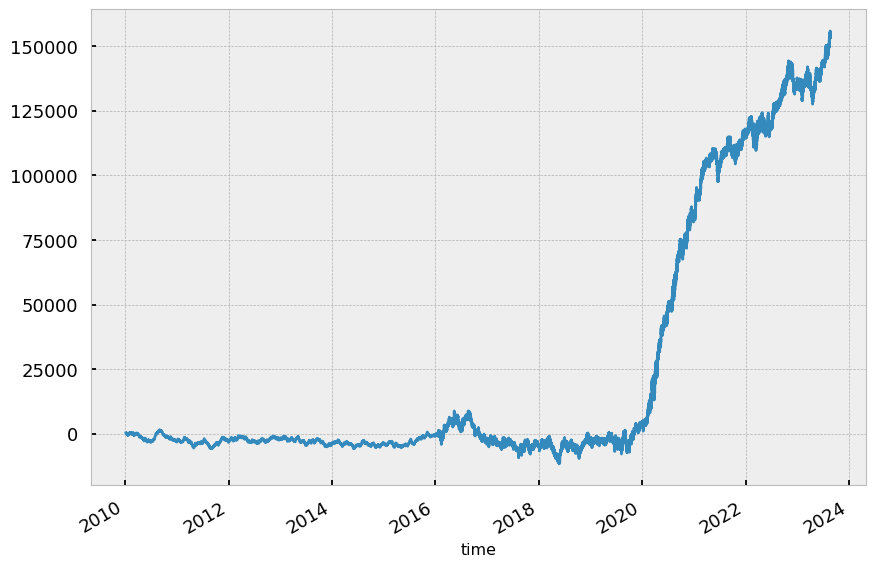

In [60]:
supert, superd, superl, supers = faster_supertrend_talib(data.high.values, data.low.values, data.close.values,10,4)
df = data.pnl.to_frame("pnl")
df["st"] = superd*(-1)
df["signal"] = np.where(df.st!=df.st.shift(1),1,0)
df["new_bal"] = df.pnl / df.st.shift(1)
df["new_bal"].cumsum().plot()

In [61]:
a = df["signal"].resample("B").sum()
a[a!=0].tail()

time
2023-08-18    6
2023-08-21    7
2023-08-22    6
2023-08-23    1
2023-08-24    1
Name: signal, dtype: int32

In [31]:
supert, superd, superl, supers = faster_supertrend_talib(data.loc["2023-08-22"].high.values, data.loc["2023-08-22"].low.values, data.loc["2023-08-22"].close.values,10,6)

In [32]:
df = data.loc["2023-08-22"].pnl.to_frame("pnl")
df["st"] = superd*(-1)
df["signal"] = np.where(df.st!=df.st.shift(1),1,0)
df["new_bal"] = df.pnl / df.st.shift(1)

<Axes: xlabel='time'>

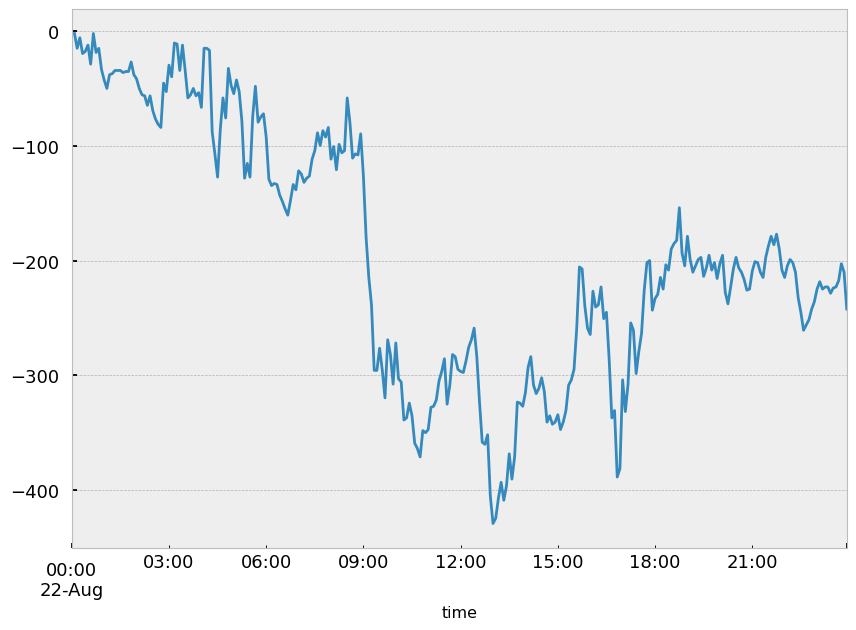

In [33]:
df["new_bal"].cumsum().plot()

In [39]:
df = df["new_bal"].copy().to_frame("pnl")
df.index = pd.to_datetime(df.index)

df["H"] = df.index.hour
df["D"] = df.index.day
df["DOW"] = df.index.dayofweek
df["M"] = df.index.month


<Axes: xlabel='H'>

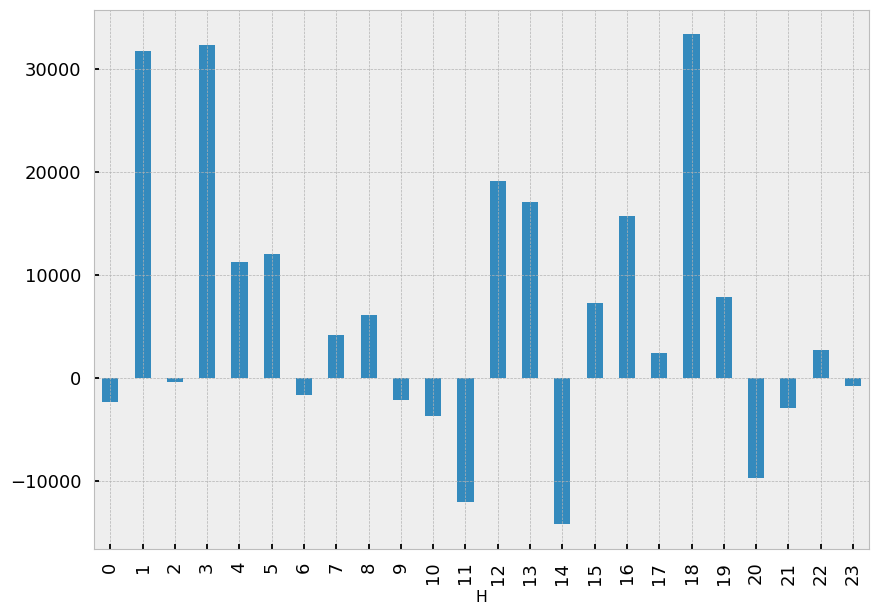

In [40]:
df.groupby("H").sum().pnl.plot.bar()

<Axes: xlabel='DOW'>

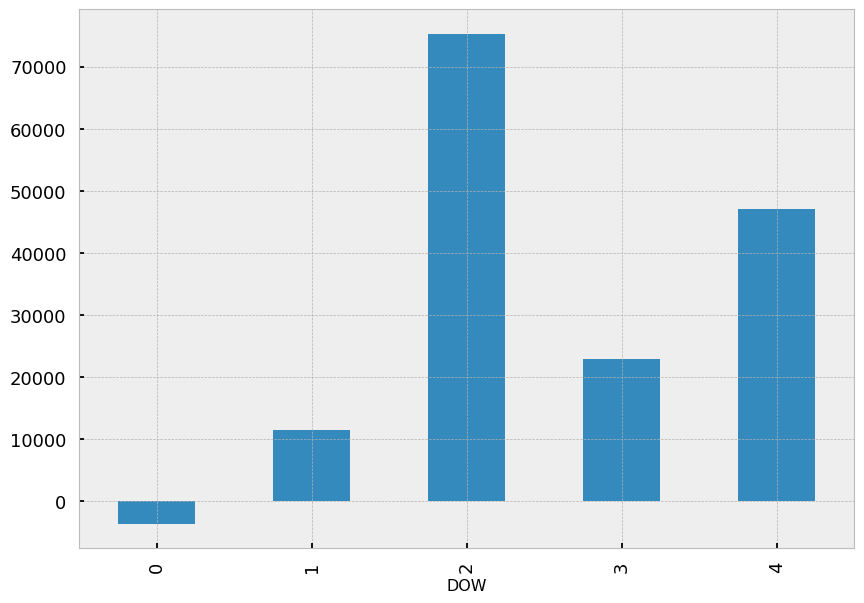

In [41]:
df.groupby("DOW").sum().pnl.plot.bar()


<Axes: xlabel='D'>

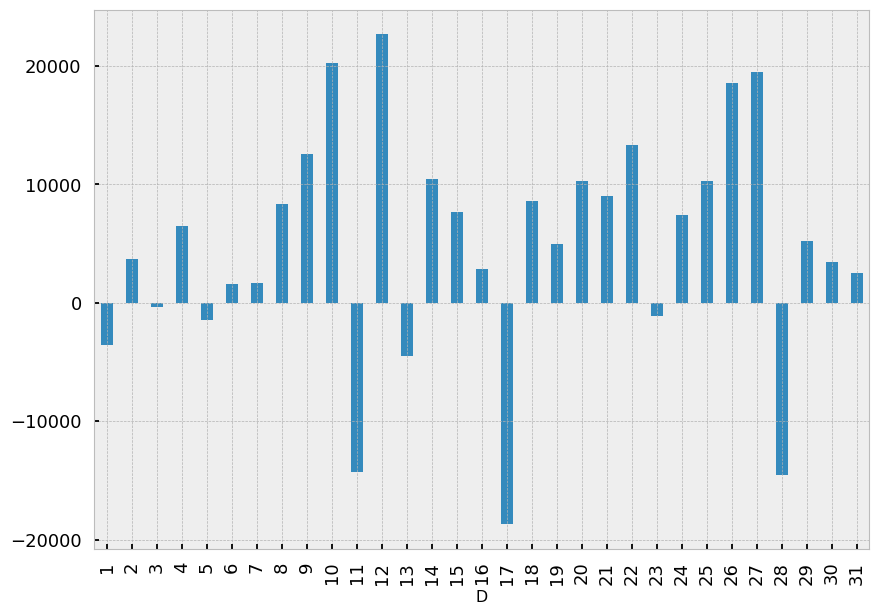

In [42]:
df.groupby("D").sum().pnl.plot.bar()

<Axes: xlabel='M'>

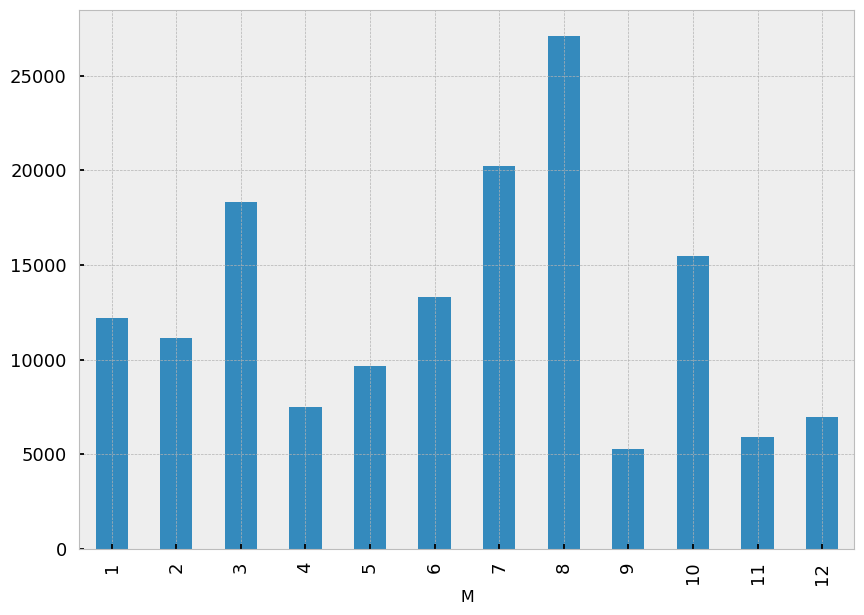

In [43]:
df.groupby("M").sum().pnl.plot.bar()

df_clean = df[(df.index.hour<24)&(df.index.dayofweek<5)&(df.index.month<11)].pnl
df_clean.cumsum().plot()

df_clean.resample("B").sum().cumsum().plot()

In [62]:

pnl = df["pnl"].to_frame("PNL").resample("H").sum()
#pnl = pnl[pnl!=0].dropna()
pnl["price"] = pnl.PNL.pct_change(1)

#for i in list(set(pnl.index.hour)):
#    pnl["H_"+str(i)] = np.where(pnl.index.hour>i,1,0)

#pnl["c_win"] = consec_win(pnl.PNL)
#pnl["c_loss"] = consec_loss(pnl.PNL)
pnl["sup"] = np.where(pnl.PNL>0,1,0)
pnl["inf"] = np.where(pnl.PNL<0,1,0)
#pnl["pcw"] =  pnl.PNL.rolling(5).apply(old_sharpe_ratio)
#pnl["body"] = df.open.shift(1)-df.close.shift(1)
#pnl["range"] = df.high.shift(1)-df.low.shift(1)
pnl["H"] = pnl.index.hour
pnl["DOW"] = pnl.index.dayofweek
#pnl["M"] = pnl.index.month
#pnl["Y"] = pnl.index.year
pnl["D"] = pnl.index.day
#pnl["Q"] = pnl.index.quarter
#pnl["W"] = pnl.index.week
#pnl["DOY"] = pnl.index.dayofyear

pnl=pnl.fillna(0)
pnl[pnl==np.inf]=0
pnl[pnl==-np.inf]=0
pnl["price"] = pnl["price"].astype(np.int8)
pnl.head()

,PNL,price,sup,inf,H,DOW,D
time,,,,,,,
2010-01-04 02:00:00,262.672811,0,1,0,2,0,4
2010-01-04 03:00:00,0.000000,-1,0,0,3,0,4
2010-01-04 04:00:00,0.000000,0,0,0,4,0,4
2010-01-04 05:00:00,0.000000,0,0,0,5,0,4
2010-01-04 06:00:00,0.000000,0,0,0,6,0,4


In [63]:
        
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)

In [64]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

stampa = False

test_long = pd.DataFrame()
test_short = pd.DataFrame()
OOS="2024-01-01"
# Supponiamo di avere già creato il dataframe 'X' contenente i dati di addestramento, e 'pnl' contenente i dati completi
X = pnl.iloc[:,1:].loc[:OOS].copy()
names = X.columns
#X = fast_GSA(X,40)[0]
X = pd.DataFrame(X,columns = names)
#X = dataset_perc.loc[:OOS].copy()

X = scaler.fit_transform(X)


n_clusters = 100

# Creazione e addestramento del modello K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=11 , n_init = 'auto' )#,n_init=100)
#kmeans = DBSCAN(eps=0.30, min_samples=3,n_jobs=-1)
kmeans.fit(X)


# Ora supponiamo di avere nuovi dati in un dataframe chiamato 'new_data'
# Esegui il clustering su nuovi dati
X = pnl.iloc[:,1:].loc[:].copy()
#X = dataset_perc.copy()
X = scaler.fit_transform(X)
profit_loss_df = pnl.loc[:].copy()
new_data_cluster_labels = kmeans.predict(X)
#new_data_cluster_labels = kmeans.labels_

# Ora 'new_data_cluster_labels' conterrà le etichette dei cluster assegnate ai nuovi dati.
profit_loss_df['Cluster'] = new_data_cluster_labels
profit_loss_df['Cluster'] = profit_loss_df['Cluster'].shift(1)
profit_loss_df["signal_long"] = 0
profit_loss_df["signal_short"] = 0

Cluster_long = []
Cluster_short = []

data = pd.DataFrame()

for cluster_id in range(n_clusters):
    cluster_data = profit_loss_df[profit_loss_df['Cluster'] == cluster_id]
    temp =  cluster_data.PNL
    data = pd.concat([data,temp.to_frame("cluster_"+str(cluster_id))])
    temp = temp[temp!=0]
    if cluster_data.PNL.loc[:OOS].sum()>0:
        profit_loss_df["signal_long"][profit_loss_df["Cluster"]==cluster_id]=1
        pct = percent_win(temp)
        if stampa:
            cluster_data.PNL.cumsum().plot(title="Cluster_Clean_N:°"+str(cluster_id)+"_"+str(pct)+"_"+str(len(temp.loc[:OOS])))
        if (percent_win(temp.loc[:OOS])>53) &(len(temp.loc[:OOS])>100):
            test_long = pd.concat([test_long,cluster_data.PNL.to_frame("Cluster_"+str(cluster_id))],axis=1)
            Cluster_long.append(cluster_id)
    else:
        profit_loss_df["signal_short"][profit_loss_df["Cluster"]==cluster_id]=-1
        temp=-temp
        pct = percent_win(temp)
        if stampa:
            (-cluster_data.PNL).cumsum().plot(title="Cluster_Noise_N:°"+str(cluster_id)+"_"+str(pct))
        if (percent_win(temp.loc[:OOS])>51) &(len(temp.loc[:OOS])>100):
            test_short = pd.concat([test_short,(-cluster_data.PNL).to_frame("Cluster_"+str(cluster_id))],axis=1)
            Cluster_short.append(cluster_id)
    #plt.axvline(x=OOS,color="red")
    if stampa:
        plt.legend()
        plt.grid(True)
        plt.show()
print("fatto")

fatto


ls_cls = ["Cluster_3","Cluster_4"]#,"Cluster_6"]

test_long[ls_cls].cumsum().plot()
plt.show()
test_long[ls_cls].sum(axis=1).cumsum().plot()

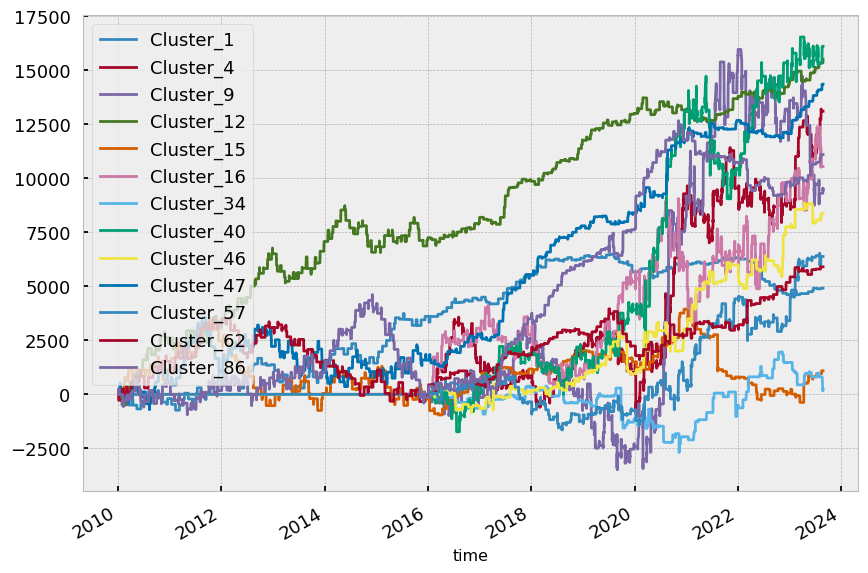

<Axes: xlabel='time'>

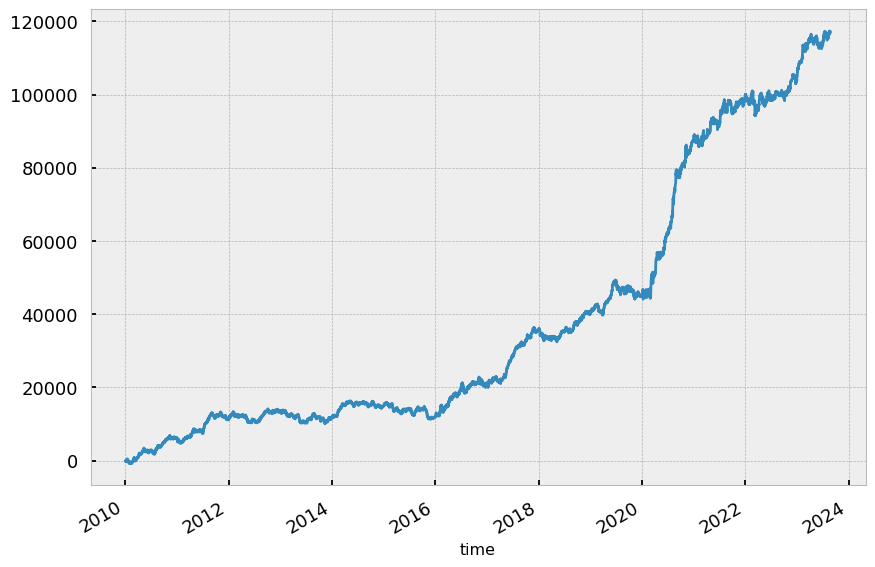

In [67]:
test_long.loc[:].fillna(0).cumsum().plot()
plt.show()
test_long.loc[:].sum(axis=1).fillna(0).cumsum().plot()

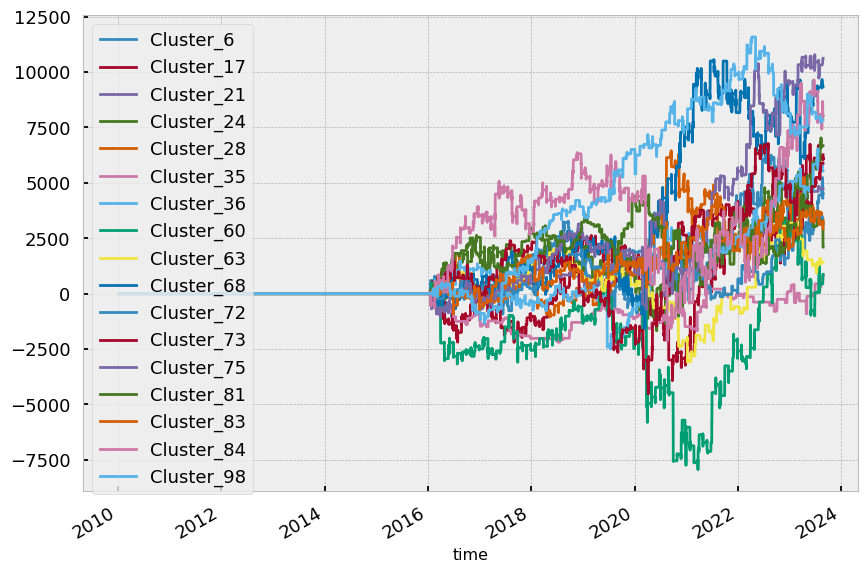

<Axes: xlabel='time'>

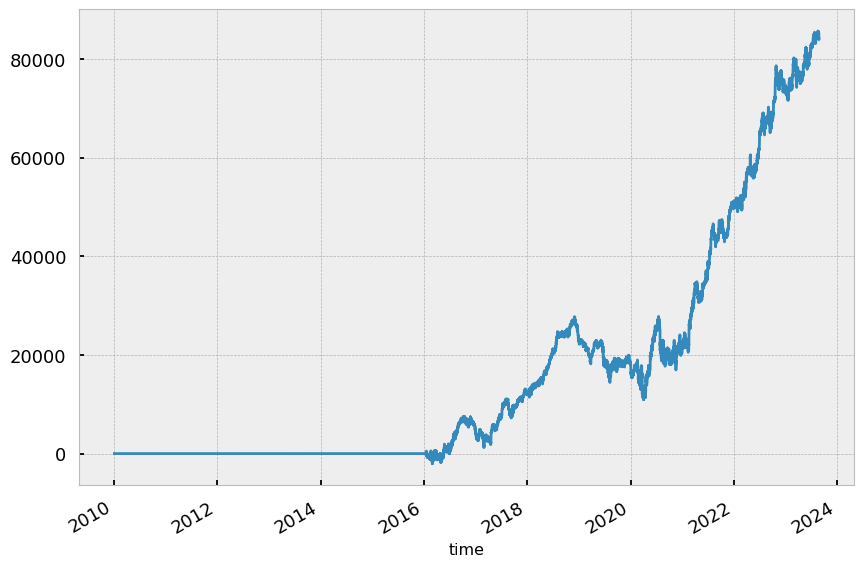

In [66]:
test_short.loc[:].fillna(0).cumsum().plot()
plt.show()
test_short.loc[:].sum(axis=1).fillna(0).cumsum().plot()